In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
# --- FUNCTION TO LOAD AND FLATTEN A SINGLE JSON FILE ---

def load_dataset(filename):
    """Load a JSON file and flatten it into a clean DataFrame."""
    with open(filename, encoding="utf-8") as f:
        data = json.load(f)

    df = pd.json_normalize(
        data,
        record_path="raw_measurements",
        meta=["version", "type", "start_time", "end_time", "sampling_rate",
              "weight_filter", "zero_offset", "expected_weight",
              "robot_type", "eoat_params"],
        errors="ignore"
    )

    # Expand vector fields into separate columns
    df[["Mx", "My", "Fz"]] = pd.DataFrame(df.pop("force_vector").tolist(), index=df.index)

    flange = pd.DataFrame(df.pop("robot_tcp.flange").tolist(), index=df.index)
    df[["flange_tx", "flange_ty", "flange_tz"]] = pd.DataFrame(flange[0].tolist(), index=df.index)
    df[["flange_qw", "flange_qx", "flange_qy", "flange_qz"]] = pd.DataFrame(flange[1].tolist(), index=df.index)

    tcp_offset = pd.DataFrame(df.pop("robot_tcp.tcp_offset").tolist(), index=df.index)
    df[["tcp_tx", "tcp_ty", "tcp_tz"]] = pd.DataFrame(tcp_offset[0].tolist(), index=df.index)
    df[["tcp_qw", "tcp_qx", "tcp_qy", "tcp_qz"]] = pd.DataFrame(tcp_offset[1].tolist(), index=df.index)

    df[["tcp_vx", "tcp_vy", "tcp_vz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_linear").tolist(), index=df.index)
    df[["tcp_wx", "tcp_wy", "tcp_wz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_angular").tolist(), index=df.index)

    df[["joint_base", "joint_shoulder", "joint_elbow",
        "joint_wrist_1", "joint_wrist_2", "joint_wrist_3"]] = pd.DataFrame(df.pop("robot_tcp.joint_angles").tolist(), index=df.index)

    # Convert timestamps to relative time in milliseconds
    start_time = df['timestamp'].min()
    df['timestamp'] = (df['timestamp'] - start_time) * 1000

    # Store file name as reference
    df["file"] = Path(filename).name

    return df


In [3]:
# --- PROCESSING ALL FILES IN FOLDER ---

# Path to the folder containing .json files
folder_path = r"G:\Force Cases Batch 1\force_cases_batch_1"

# List to store extracted weights from each file
weights_info = []

# Track processed and failed files
processed_files = 0
failed_files = 0

# Read and process each JSON file in the folder
for file in os.listdir(folder_path):
    if file.endswith(".json"):
        try:
            full_path = os.path.join(folder_path, file)
            df = load_dataset(full_path)

            # Use only the first occurrence of the estimated weight
            if "expected_weight" in df.columns:
                weight = df["expected_weight"].iloc[0]
                weights_info.append({"file": file, "expected_weight": weight})
                processed_files += 1

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            failed_files += 1

# Create DataFrame with all extracted weights
weights_df = pd.DataFrame(weights_info)

# Summary
print(f"\n Total files processed successfully: {processed_files}")
print(f"Total files with errors: {failed_files}")
print(f"Total JSON files scanned: {processed_files + failed_files}")

Error processing file 2025-06-15_16-51-03-953487_measure_weight_FORCE_MEASUREMENT_CASE.json: Expecting ',' delimiter: line 20103 column 40 (char 623746)


In [5]:
# Categorize estimated weights into bins
def classify_weight(weight):
    if weight < 0.1:
        return "Light (<100g)"
    elif 0.1 <= weight <= 0.3:
        return "Medium (100–300g)"
    else:
        return "Heavy (>300g)"

weights_df["category"] = weights_df["expected_weight"].apply(classify_weight)

# Count number of cases per category
# Define desired order
ordered_categories = ["Light (<100g)", "Medium (100–300g)", "Heavy (>300g)"]
category_counts = weights_df["category"].value_counts().reindex(ordered_categories)

print (category_counts)
total_files = category_counts.sum()
print(f"📦 Total files classified: {total_files}")

category
Light (<100g)         652
Medium (100–300g)    1367
Heavy (>300g)        1476
Name: count, dtype: int64
📦 Total files classified: 3495


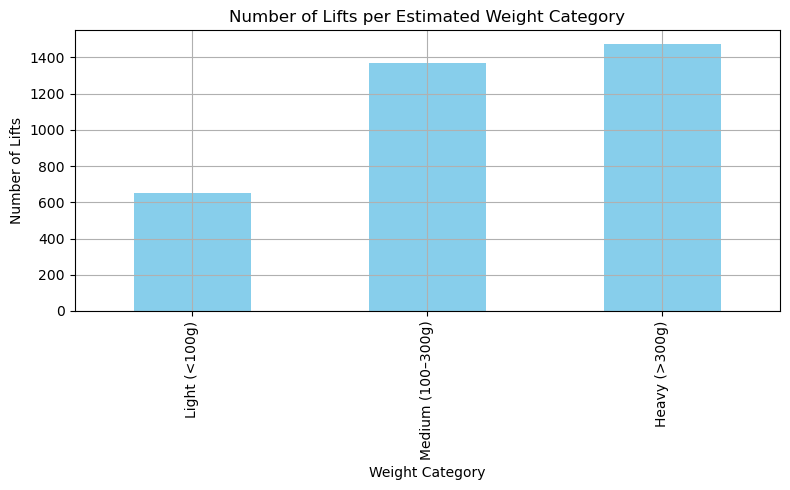

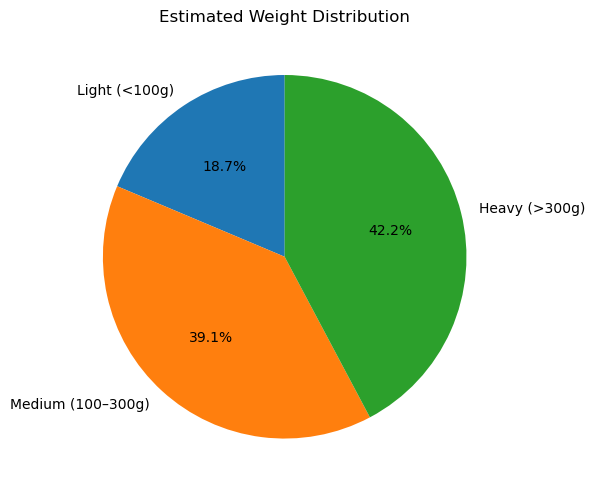

In [6]:
# --- VISUALIZATION ---

# Bar chart of weight categories
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Lifts per Estimated Weight Category")
plt.xlabel("Weight Category")
plt.ylabel("Number of Lifts")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pie chart of weight categories
plt.figure(figsize=(6, 6))
category_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Estimated Weight Distribution")
plt.ylabel("")  # Remove default ylabel
plt.tight_layout()
plt.show()